# Mini-Project 1
**Author**: Farkhad Kuanyshkereyev<br>
**Course**: Machine Learning<br>
**Professor**: Sepinoud Azimi Rashti

## **Step 1 - Importing Packages**

In [1]:
# Importing necessary packages

from google.colab import files
from IPython.display import SVG
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(0)
THRESHOLD = 0.5

## **Step 2 - Data Processing**

In [2]:
# Uploading the dataset CSV file

file_name = "bank-additional-full.csv"
files.upload()

df = pd.read_csv(f"./{file_name}", sep=';')

Saving bank-additional-full.csv to bank-additional-full.csv


In [3]:
# Checking for missing values

df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

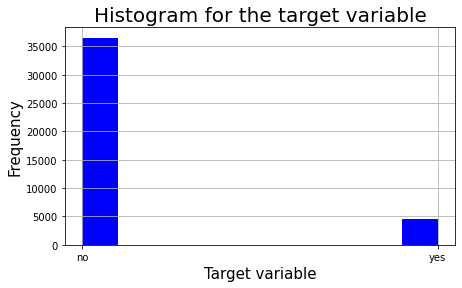

In [4]:
# Checking the class distribution
# The dataset is imbalanced

plt.subplots(figsize=(7, 4))
df["y"].hist(color="blue")
plt.title("Histogram for the target variable", fontsize=20)
plt.xlabel("Target variable", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

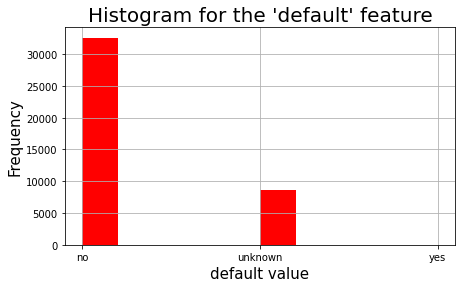

In [5]:
# Checking the default column
# It has many unknown values and only 3 positive values
# It cannot be useful for the prediction

plt.subplots(figsize=(7, 4))
df["default"].hist(color="red")
plt.title("Histogram for the 'default' feature", fontsize=20)
plt.xlabel("default value", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

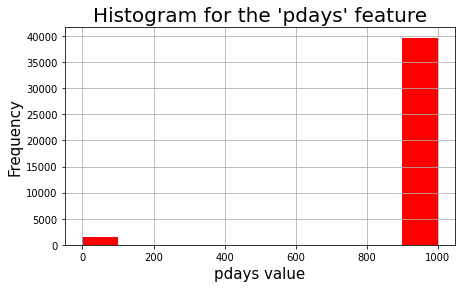

In [6]:
# The pdays column contains a lot of unknown values (999)
# Hence it cannot be useful for the prediction

plt.subplots(figsize=(7, 4))
df["pdays"].hist(color="red")
plt.title("Histogram for the 'pdays' feature", fontsize=20)
plt.xlabel("pdays value", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.show()

In [7]:
# Dropping the duration column because it cannot be used as a predictor
# Dropping other columns because they are not useful

df = df.drop(columns=["default", "duration", "pdays"])

In [8]:
# Mapping education to ordered list

education_mapping = {
    "unknown": -999,
    "illiterate": 0,
    "basic.4y": 1,
    "basic.6y": 2,
    "basic.9y": 3,
    "high.school": 4,
    "university.degree": 5,
    "professional.course": 6
}

df["education"] = df["education"].map(lambda x: education_mapping[x])

In [9]:
# Defining lists of features by their type

categorical_features = ["job", "marital", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
numerical_features = ["age", "education", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

In [10]:
# Using One-Hot Encoding on categorical features

categorical_df = pd.get_dummies(df[categorical_features])
categorical_df

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [11]:
# Defining the training dataset by combining all remaining numerical and categorical features

train_df = df[numerical_features]
train_df[list(categorical_df.columns)] = categorical_df[list(categorical_df.columns)]
all_columns = list(train_df.columns)
train_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,4,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,4,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,2,1,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,4,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,6,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,6,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,5,2,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,6,1,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [12]:
# Mapping the values of target variable y to integers, where 1 denotes 'yes' and 0 denotes 'no'

df['y'] = df['y'].map(lambda x: 1 if x == "yes" else 0)

In [13]:
# Defining the weights of classes based on their proportion in the dataset

class_weight = {
    0: 1 - len(df[df['y'] == 0]) / len(df),
    1: 1 - len(df[df['y'] == 1]) / len(df)
}

class_weight

{0: 0.1126541711178013, 1: 0.8873458288821987}

In [14]:
# Printing the data type and count information about the features of the dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   education             41188 non-null  int64  
 2   campaign              41188 non-null  int64  
 3   previous              41188 non-null  int64  
 4   emp.var.rate          41188 non-null  float64
 5   cons.price.idx        41188 non-null  float64
 6   cons.conf.idx         41188 non-null  float64
 7   euribor3m             41188 non-null  float64
 8   nr.employed           41188 non-null  float64
 9   job_admin.            41188 non-null  uint8  
 10  job_blue-collar       41188 non-null  uint8  
 11  job_entrepreneur      41188 non-null  uint8  
 12  job_housemaid         41188 non-null  uint8  
 13  job_management        41188 non-null  uint8  
 14  job_retired           41188 non-null  uint8  
 15  job_self-employed  

In [15]:
# Showing the numerical description of the features dataset

train_df.describe()

,age,education,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,-38.166845,2.567593,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,0.008012,0.111974,0.605225,0.280859,0.001942,0.452122,0.024036,0.523842,0.824269,0.024036,0.151695,0.634748,0.365252,0.063902,0.149995,0.004419,0.174177,0.129115,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,10.42125,201.256993,2.770014,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,0.089152,0.315339,0.488808,0.449424,0.044029,0.497708,0.153163,0.499437,0.380596,0.153163,0.358729,0.481507,0.481507,0.244581,0.357071,0.066328,0.379266,0.335332,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,17.00000,-999.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,3.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,4.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,47.00000,5.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000

In [16]:
# Standardizing all of the feature values for faster training

target_df = df['y']

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)

train_df.shape

(41188, 51)

In [17]:
# Calculating the Pearson correlation of feature values with the target variable

temp_df = pd.DataFrame(train_df, columns=all_columns)
temp_df['y'] = df['y']
temp_df.corr()['y']

age                     0.030399
education              -0.021134
campaign               -0.066357
previous                0.230181
emp.var.rate           -0.298334
cons.price.idx         -0.136211
cons.conf.idx           0.054878
euribor3m              -0.307771
nr.employed            -0.354678
job_admin.              0.031426
job_blue-collar        -0.074423
job_entrepreneur       -0.016644
job_housemaid          -0.006505
job_management         -0.000419
job_retired             0.092221
job_self-employed      -0.004663
job_services           -0.032301
job_student             0.093955
job_technician         -0.006149
job_unemployed          0.014752
job_unknown            -0.000151
marital_divorced       -0.010608
marital_married        -0.043398
marital_single          0.054133
marital_unknown         0.005211
housing_no             -0.011085
housing_unknown        -0.002270
housing_yes             0.011743
loan_no                 0.005123
loan_unknown           -0.002270
loan_yes  

## **Step 3 - Modeling**

In [18]:
# Splitting the dataset into the train, validation, and test sets

X_train, X_test, y_train, y_test = train_test_split(train_df, target_df, stratify=target_df, test_size=0.1, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (37069, 51)
y_train shape: (37069,)
X_valid shape: (2059, 51)
y_valid shape: (2059,)
X_test shape: (2060, 51)
y_test shape: (2060,)


In [19]:
# Defining and showing the neural network model

network = models.Sequential()

network.add(layers.Dropout(0.2, input_shape=(train_df.shape[1],)))
network.add(layers.Dense(units=32, activation="relu"))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=32, activation="relu"))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=1, activation="sigmoid"))

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 51)                0         
                                                                 
 dense (Dense)               (None, 32)                1664      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainabl

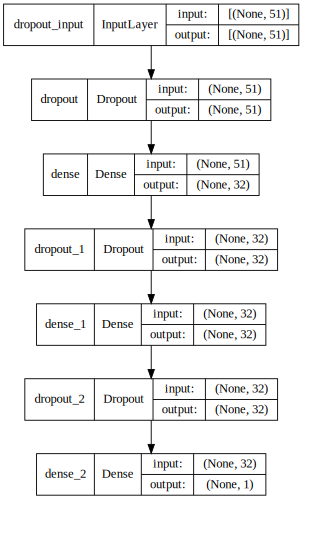

In [20]:
SVG(model_to_dot(network, show_shapes=True, dpi=65).create(prog="dot", format="svg"))

In [21]:
# Compiling the neural network model with the specified configurations

network.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "AUC"]
)

In [22]:
# Defining the callbacks of EarlyStopping and ModelCheckpoint for saving the best model

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=50),
    ModelCheckpoint(filepath="temp_model.h5", monitor="val_accuracy", save_best_only=True)
]

In [23]:
# Fitting the model on the training dataset

history = network.fit(
    X_train,
    y_train,
    epochs=200,
    callbacks=callbacks,
    verbose=1,
    batch_size=256,
    validation_data=(X_valid, y_valid),
    class_weight=class_weight
)

Epoch 1/200
145/145 [==============================] - 2s 5ms/step - loss: 0.1569 - accuracy: 0.5411 - auc: 0.5816 - val_loss: 0.6621 - val_accuracy: 0.6921 - val_auc: 0.7448
Epoch 2/200
145/145 [==============================] - 1s 3ms/step - loss: 0.1324 - accuracy: 0.6387 - auc: 0.6660 - val_loss: 0.6165 - val_accuracy: 0.7610 - val_auc: 0.7579
Epoch 3/200
145/145 [==============================] - 1s 4ms/step - loss: 0.1244 - accuracy: 0.7016 - auc: 0.7144 - val_loss: 0.6018 - val_accuracy: 0.7839 - val_auc: 0.7614
Epoch 4/200
145/145 [==============================] - 1s 3ms/step - loss: 0.1227 - accuracy: 0.7402 - auc: 0.7293 - val_loss: 0.5903 - val_accuracy: 0.8116 - val_auc: 0.7617
Epoch 5/200
145/145 [==============================] - 0s 3ms/step - loss: 0.1185 - accuracy: 0.7699 - auc: 0.7500 - val_loss: 0.5826 - val_accuracy: 0.8169 - val_auc: 0.7611
Epoch 6/200
145/145 [==============================] - 0s 3ms/step - loss: 0.1176 - accuracy: 0.7840 - auc: 0.7551 - val_loss

## **Step 4 - Performance Evaluation**

In [24]:
# Defining the visualization function

def plot_performance_evaluation(history, metric):
    training_values = history.history[metric.lower()]
    test_values = history.history[f"val_{metric.lower()}"]
    epoch_count = range(1, len(training_values) + 1)

    plt.subplots(figsize=(7, 4))
    plt.plot(epoch_count, training_values, "r--")
    plt.plot(epoch_count, test_values, "b-")
    plt.title(f"{metric} Plot", fontsize=20)
    plt.legend([f"Training {metric}", f"Test {metric}"], fontsize=15)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel(metric, fontsize=15)
    plt.grid()
    plt.show()

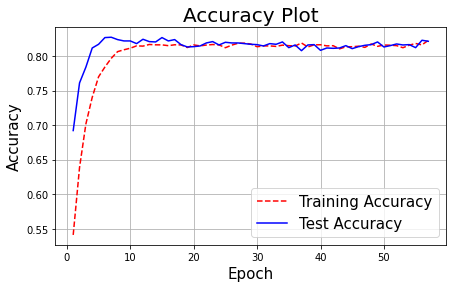

In [25]:
# Showing the accuracy plot

plot_performance_evaluation(history, "Accuracy")

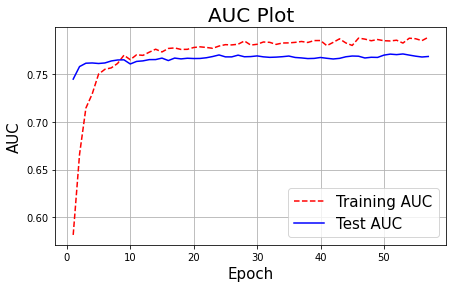

In [26]:
# Showing the AUC plot

plot_performance_evaluation(history, "AUC")

In [27]:
# Predicting the values for the validation dataset

y_pred = network.predict(X_valid)

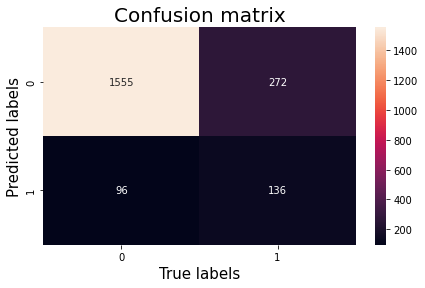

In [28]:
# Visualizing the confusion matrix for the target variable

cf_matrix = confusion_matrix(y_valid, y_pred > THRESHOLD)

plt.subplots(figsize=(7, 4))
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.title("Confusion matrix", fontsize=20)
plt.xlabel("True labels", fontsize=15)
plt.ylabel("Predicted labels", fontsize=15)
plt.show()

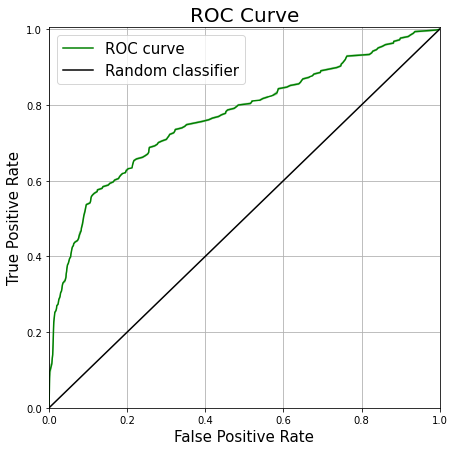

In [29]:
# Plotting the ROC curve for the validation dataset

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

plt.subplots(figsize=(7, 7))
sns.lineplot(x=fpr, y=tpr, color="green")
plt.plot([0, 1], [0, 1], color="black")
plt.title("ROC Curve", fontsize=20)
plt.legend(["ROC curve", "Random classifier"], fontsize=15)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.xlim([0, 1])
plt.ylim([0, 1.005])
plt.grid()
plt.show()

In [30]:
# Finding the accuracy score for the validation dataset

y_pred = network.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred > THRESHOLD)
print("Accuracy for the validation dataset: %.2f %%" % (accuracy * 100))

Accuracy for the validation dataset: 82.13 %


In [31]:
# Finding the accuracy score for the validation dataset

y_pred = network.predict(X_test)
accuracy = accuracy_score(y_test, y_pred > THRESHOLD)
print("Accuracy for the validation dataset: %.2f %%" % (accuracy * 100))

Accuracy for the validation dataset: 83.88 %


In [32]:
# Uploading the best model in H5 format

file_name = "best_model.h5"
files.upload()

model = models.load_model(f"./{file_name}")

Saving best_model.h5 to best_model.h5


In [33]:
# Finding the accuracy score for the validation dataset with the best model

y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred > THRESHOLD)
print("Accuracy for the validation dataset: %.2f %%" % (accuracy * 100))

Accuracy for the validation dataset: 82.81 %


In [34]:
# Finding the accuracy score for the test dataset with the best model

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred > THRESHOLD)
print("Accuracy for the test dataset: %.2f %%" % (accuracy * 100))

Accuracy for the test dataset: 84.56 %
